In [18]:
import mne
from mne.preprocessing import (ICA)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import mat73

# Load data

In [19]:
def load_session(path, sampling_freq, eeg_ch_names):
    # load raw numpy data
    mat = mat73.loadmat(path)
    mat = mat['y']

    # build metadata structure
    ch_names = eeg_ch_names + ['stim1'] 
    ch_types = (['eeg'] * 8) + ['stim']
    info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types=ch_types)

    mat[1:9] = mat[1:9] * 1E-6 # mne expect raw data in Volt, loaded data is in micro volts!
    raw = mne.io.RawArray(mat[1:10], info) # index 1-10 only for EEG and stim channels

    return raw

Creating RawArray with float64 data, n_channels=9, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


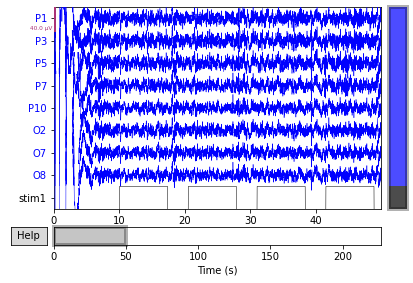

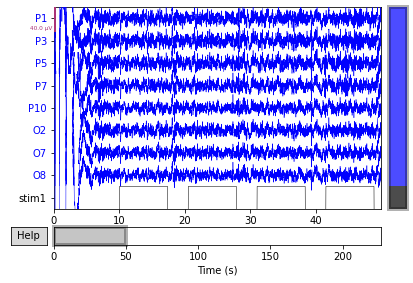

In [20]:
fs = 256
CH_NAMES = ['P1','P3','P5','P7','P10','O2','O7','O8']
subj1_session1 = Path('new_data\subject_1_fvep_led_training_2.mat')

raw = load_session(subj1_session1, fs, CH_NAMES)

raw.plot(duration=50, color={'eeg':'blue'})

40 events found
Event IDs: [0 1]


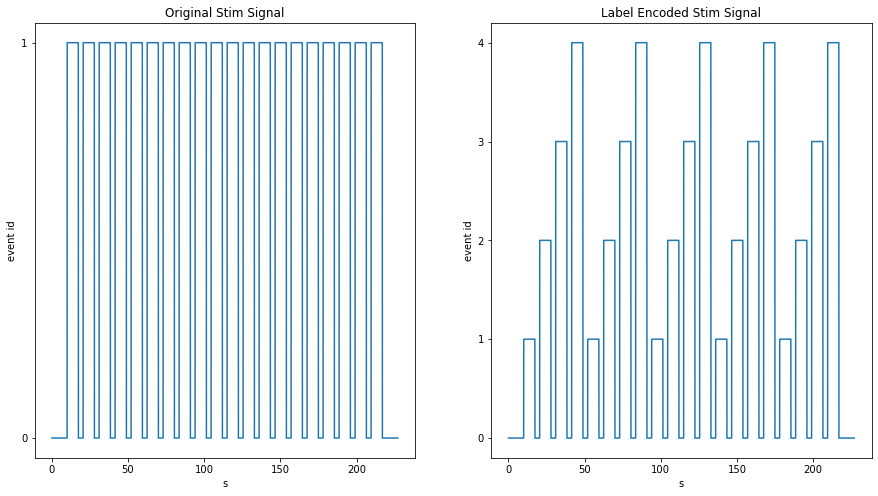

In [21]:
def add_labels_to_stim(raw, n_trials=4):
    events = mne.find_events(raw, stim_channel='stim1', output='step')

    on_set_mask = events[:,2] == 1 # stim channel goes from 0 to 1
    on_set_events = events[on_set_mask, 0]

    off_set_mask = events[:,2] == 0  # stim channel goes from 1 to 0
    off_set_events = events[off_set_mask,0]

    raw_copy = raw.copy() # do not effect the original raw signal
    data = raw_copy._data # directly access the underlying numpy data!

    # loop trough events and encode the label as a stim channel event_id
    for i, (on_set, off_set) in enumerate(zip(on_set_events, off_set_events)):
        trial_label = (i % n_trials) +1 # just a trick to avoid looping i in range(1,5)
        data[8, on_set:off_set] = trial_label # modify the stim channel (index 8)

    return raw_copy

raw2 = add_labels_to_stim(raw)

orig_stim, times = raw[8]
modified_stim, times = raw2[8]


fig, axes = plt.subplots(ncols=2, figsize=(15,8))

axes[0].plot(times, orig_stim[0])
axes[0].set_title('Original Stim Signal')
axes[1].plot(times, modified_stim[0])
axes[1].set_title('Label Encoded Stim Signal')

for ax in axes:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlabel('s')
    ax.set_ylabel('event id')

In [22]:
data = raw2.get_data()
np.save(file='data_raw.npy', arr=data)

raw2.save("data_raw.fif", overwrite=True)

Overwriting existing file.
Writing C:\Users\huawei\My_notebook\SSVEP\data_raw.fif
Closing C:\Users\huawei\My_notebook\SSVEP\data_raw.fif
[done]


Opening raw data file data_raw.fif...
Isotrak not found
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.
Reading 0 ... 58111  =      0.000 ...   226.996 secs...


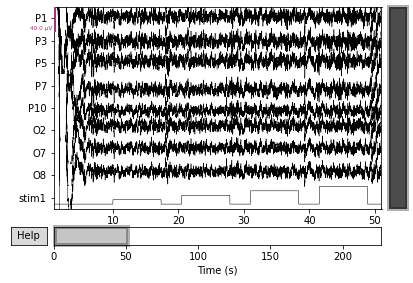

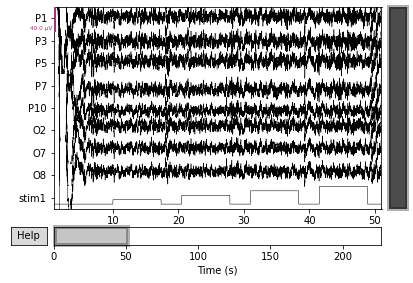

In [23]:
raw = mne.io.read_raw_fif("data_raw.fif", preload = True)
raw.plot(start=1, duration=50)

In [24]:
raw.get_data().shape

(9, 58112)

In [25]:
raw_label = raw.copy()

In [26]:
label=raw_label.get_data()[8,:]

In [27]:
label.shape

(58112,)

In [28]:
hf=None

# Raw

In [29]:
import numpy as np

In [30]:
raw_eeg = raw.pick_types(eeg=True)
raw_eeg

<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [31]:
np_raw=np.vstack([raw_eeg.get_data(), label])

# Filt 40 Hz

In [32]:
filt=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



# Filt + ICA

In [33]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


<ipython-input-34-fa5f295f6cd8>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=8)


Fitting ICA took 0.6s.
Creating RawArray with float64 data, n_channels=8, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


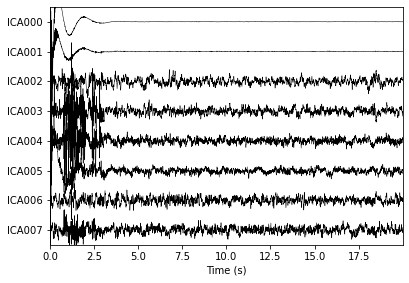

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [34]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [35]:
filt_ICA = reconst_raw.copy()

In [36]:
np_filt_ICA = np.vstack([filt_ICA.get_data(), label])

# Filt + CAR

In [37]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



In [38]:
avg_ref = filt_eeg.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [39]:
filt_CAR = avg_ref.copy()

In [40]:
np_filt_CAR = np.vstack([filt_CAR.get_data(), label])

# Filt + ICA + CAR

In [41]:
filt_eeg = raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


<ipython-input-42-fa5f295f6cd8>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=8)


Fitting ICA took 0.3s.
Creating RawArray with float64 data, n_channels=8, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


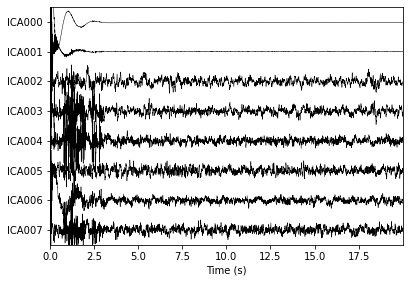

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [42]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [43]:
avg_ref = reconst_raw.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [44]:
filt_ica_car = avg_ref.copy()

In [45]:
np_filt_ica_car = np.vstack([filt_ica_car.get_data(), label])

In [46]:
np_filt_ica_car.shape

(9, 58112)

In [47]:
#np.save(file='Risultati/np_raw2', arr=np_raw)
#np.save(file='Risultati/np_filt_ICA2', arr=np_filt_ICA)
#np.save(file='Risultati/np_filt_CAR2', arr=np_filt_CAR)
#np.save(file='Risultati/np_filt_ica_car2', arr=np_filt_ica_car)

In [48]:
"""np.save(file='Risultati/np_hf40_raw2', arr=np_raw)
np.save(file='Risultati/np_hf40_ICA2', arr=np_filt_ICA)
np.save(file='Risultati/np_hf40_CAR2', arr=np_filt_CAR)
np.save(file='Risultati/np_hf40_ica_car2', arr=np_filt_ica_car)"""

"np.save(file='Risultati/np_hf40_raw2', arr=np_raw)\nnp.save(file='Risultati/np_hf40_ICA2', arr=np_filt_ICA)\nnp.save(file='Risultati/np_hf40_CAR2', arr=np_filt_CAR)\nnp.save(file='Risultati/np_hf40_ica_car2', arr=np_filt_ica_car)"

# Riconverto in .fif

In [341]:
np_filt_ica_car2 = np.load('Risultati/np_filt_ica_car1.npy')
fs = 256
ch_names = ['P1','P3','P5','P7','P10','O2','O7','O8','stim']
ch_types = (['eeg'] * 8) + ['stim']

info = mne.create_info(ch_names, sfreq=fs, ch_types=ch_types)
data = mne.io.RawArray(np_filt_ica_car2, info) # index 1-10 only for EEG and stim channels

Creating RawArray with float64 data, n_channels=9, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


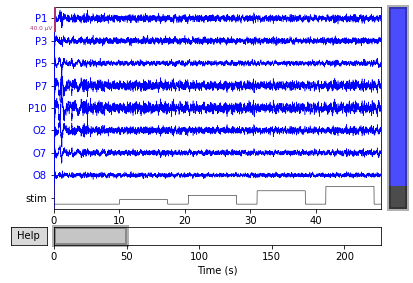

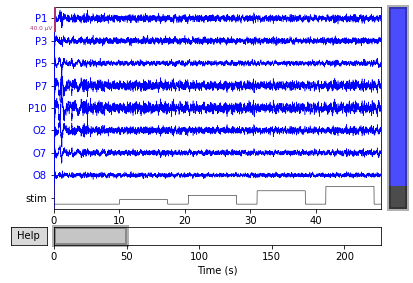

In [342]:
data.plot(duration=50, color={'eeg':'blue'})

In [343]:
np.unique(data.get_data()[8])

array([0., 1., 2., 3., 4.])

# PSD

In [344]:
# Construct epochs
event_id = {'9Hz': 1, '10Hz': 2, '12Hz': 3, '15Hz': 4}
events = mne.find_events(data, stim_channel='stim')
baseline = None

tmin= 0
tmax = 7.35  # in s

epochs = mne.Epochs(
        data, events=events,
        event_id=event_id, tmin=tmin,
        tmax=tmax, baseline=baseline, verbose=True)

20 events found
Event IDs: [1 2 3 4]
Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


In [345]:
type(epochs)

mne.epochs.Epochs

In [346]:
data15 = epochs['9Hz']
data12 = epochs['10Hz']
data10 = epochs['12Hz']
data9 = epochs['15Hz']

Loading data for 5 events and 1883 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-347-971697676f25>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data15.plot_psd(fmin = 3, fmax = 32, tmin=3, tmax=6)


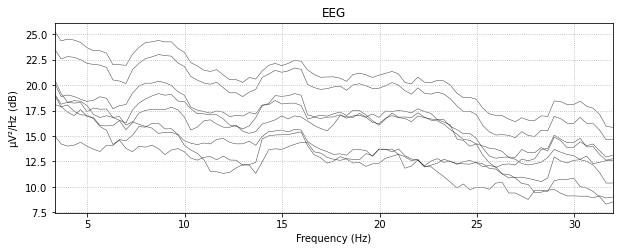

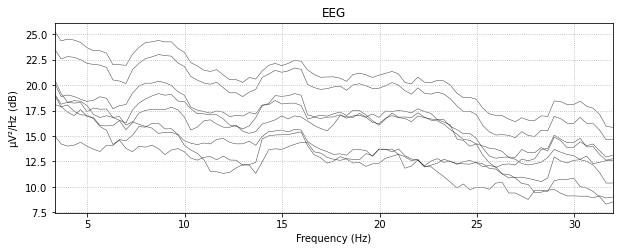

In [347]:
data15.plot_psd(fmin = 3, fmax = 32, tmin=3, tmax=6)

In [348]:
data9.get_data().shape

Loading data for 5 events and 1883 original time points ...
0 bad epochs dropped


(5, 9, 1883)

# TIME FREQUENCY ANALISYS

In [349]:
import numpy as np
import mne

times = np.linspace(1/1883, 7.35, num=1883)
len(times)
times

array([5.31067446e-04, 4.43620503e-03, 8.34134261e-03, ...,
       7.34218972e+00, 7.34609486e+00, 7.35000000e+00])

In [350]:
freqs = np.linspace(5.0, 32.0, num=28)        # define frequencies of interest
n_cycles = freqs * 2                       # different number of cycle per frequency

tfr = mne.time_frequency.tfr_multitaper(epochs, freqs, n_cycles=n_cycles, average = False, return_itc = False)

Loading data for 20 events and 1883 original time points ...
0 bad epochs dropped
Not setting metadata


In [351]:
freqs

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32.])

In [352]:
tfr

<EpochsTFR | time : [0.000000, 7.351562], freq : [5.000000, 32.000000], epochs : 20, channels : 8, ~64.4 MB>

In [353]:
tfr.data.shape

(20, 8, 28, 1883)

In [354]:
tfr_avech = np.mean(tfr.data, axis=1)
tfr_avech.shape

(20, 28, 1883)

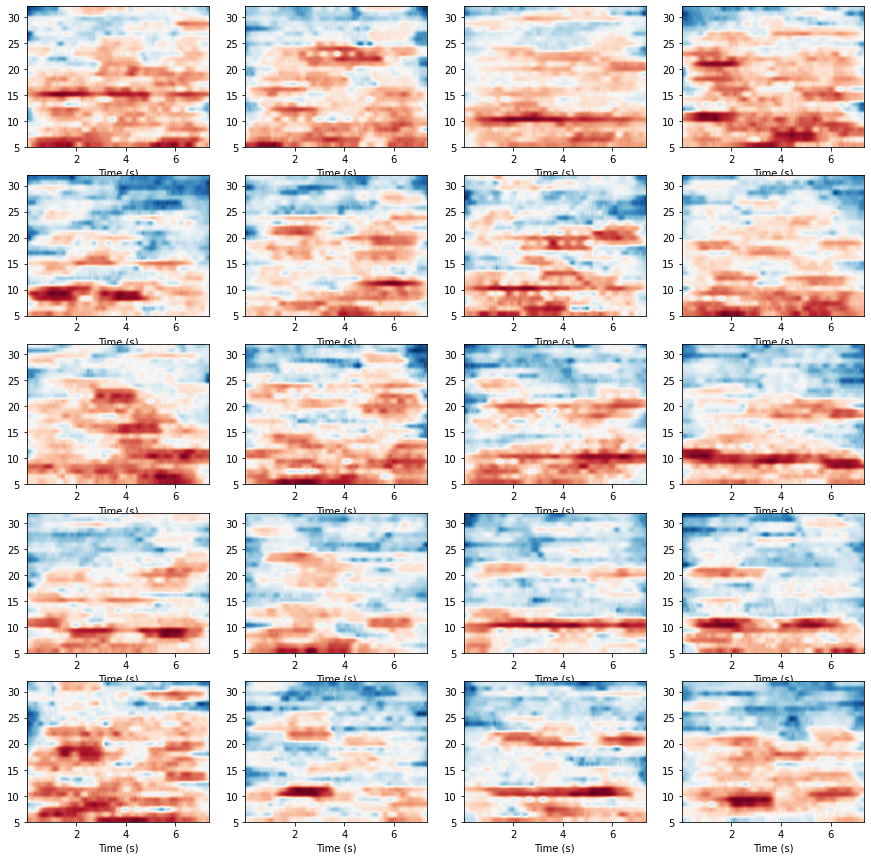

In [355]:
fig, axes = plt.subplots(5,4,figsize=(15,15))

tfr_avech = 10. * np.log10(tfr_avech)

for epoch, ax in zip(tfr_avech, axes.ravel()):
    # View time-frequency plots
    ax.imshow(epoch,
               extent=[times[0], times[-1], freqs[0], freqs[-1]],
               aspect='auto', origin='lower', cmap='RdBu_r')
    ax.set(xlabel='Time (s)')

In [356]:
tfr_avech.shape

(20, 28, 1883)

In [357]:
np.save('tfr_ica_car_1',arr=tfr_avech)

# CUMSUM metodo LUCA BOTTERO

In [358]:
sum = np.cumsum(tfr_avech, axis = 2)
sum.shape

(20, 28, 1883)

In [359]:
sum[:,:,-1].shape
#feat15 = 
#feat12
#feat10
#feat9

sum[:,:,256]

array([[-25794.99468007, -26037.4770401 , -27264.91632342,
        -26989.45686545, -27462.81472803, -27568.32811213,
        -27289.49697085, -26973.56197351, -27038.45252113,
        -26518.57188461, -25696.44335667, -26442.33322277,
        -26801.15809019, -26740.21271097, -27109.57151838,
        -27217.72472982, -27538.09190928, -27771.97024003,
        -27067.81242676, -26872.75490005, -27533.95609931,
        -28177.67785753, -27922.10999989, -27691.88969394,
        -27320.8207424 , -27498.73895204, -28573.57861202,
        -29083.64505789],
       [-25393.16746169, -26260.23852532, -26618.21591741,
        -26603.46798429, -27042.33983479, -27448.68003019,
        -27446.93854706, -27885.00406466, -27740.19662663,
        -27384.54121497, -26766.72512665, -26592.84464358,
        -27486.21240727, -27196.6250048 , -27830.82522742,
        -28076.13271465, -27356.97110957, -27496.19520488,
        -27684.47609877, -27766.92278433, -28197.3475185 ,
        -27645.26400137, -2788

In [360]:
feature_ari2 = sum[:,:,256]
feature_ari2.shape

(20, 28)

In [361]:
feature_ari = sum[:,:,-1]
feature_ari.shape

(20, 28)

In [363]:
np.save('20feature_ari',arr=feature_ari)